In [1]:
!pip install torchgan

import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision
from torch.utils.data import Subset, TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
from random import shuffle

import torchgan
from torchgan.models import ConditionalGANGenerator, ConditionalGANDiscriminator
from torchgan.losses import LeastSquaresGeneratorLoss, LeastSquaresDiscriminatorLoss
from torchgan.trainer import Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Defaulting to user installation because normal site-packages is not writeable


### Arguments

In [2]:
args = {
    'lr': 1e-3, 
    'bs': 128, 
    'epochs': 5,
    'cgan_epochs': 40,
    'num_tasks': 5,
    'dataset': "FashionMNIST",
    'num_classes': 10, 
    'in_size': 32,
    'n_channels': 1,
    'hidden_size': 50
    }

In [3]:
cgan_network = {
    "generator": {
        "name": ConditionalGANGenerator,
        "args": {
            "encoding_dims": 10,
            "num_classes": 2,
            "out_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh(),
        },
        "optimizer": {"name": torch.optim.Adam, "args": {"lr": 0.0005, "betas": (0.5, 0.999)}},
    },
    "discriminator": {
        "name": ConditionalGANDiscriminator,
        "args": {
            "num_classes": 2,
            "in_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Sigmoid(),
        },
        "optimizer": {"name": torch.optim.Adam, "args": {"lr": 0.0003, "betas": (0.5, 0.999)}},
    },
}


### Data

In [4]:

def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.5), (0.5) #(0.1307), (0.3081)
    elif dataset == 'CIFAR10':
        mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
    elif dataset == 'FashionMNIST':
        mean, std = (0.5), (0.5) #(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std),
        torchvision.transforms.Resize((32, 32))])
    
    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )
    
    return train_dataset, val_dataset


def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

### Metrics & plotting

In [5]:
def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array


def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()


def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=e)
    plt.legend()
    plt.show()


def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc


def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt


def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

def show(imgs):
    imgs = imgs[:min(len(imgs), 20)]
    imgs = torch.clip(imgs*0.5 + 0.5, 0, 1)
    grid_img = torchvision.utils.make_grid(imgs, nrow=5).to("cpu")
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

## GAN

In [6]:
lsgan_losses = [LeastSquaresGeneratorLoss(), LeastSquaresDiscriminatorLoss()]

In [7]:
def collate_fn(batch):
    examples, labels = zip(*batch)
    unq = np.unique(labels)
    m = {cls:i for i, cls in enumerate(unq)}
    labels = [m[label] for label in labels]
    return torch.stack(examples), torch.Tensor(labels)

## Class incremental model

In [8]:
class Agent:
    def __init__(self, args, train_datasets, val_datasets, class_split):
        self.args = args
        self.model = MLP(self.args)
        self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets
        self.class_split = class_split
        self.gan_trainers = [Trainer(cgan_network, lsgan_losses, sample_size=args['bs'], epochs=args['cgan_epochs'], device=device, ncritic=-2) 
                             for _ in range(len(class_split))]
        self.samples_per_class = 400
    
    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}

    def generate_data(self, task_idx, loader):
        samples, targets = torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        for sample, target in loader:
            samples = torch.cat((samples, sample.to(device)))
            targets = torch.cat((targets, target.to(device)))
        
        samples = samples[:self.samples_per_class]
        targets = targets[:self.samples_per_class]
        
        for i in range(task_idx):
            for j, cls in enumerate(class_split[str(i)]):
                z = torch.randn(self.samples_per_class, 10, device=device)
                y = torch.Tensor([j]*self.samples_per_class).to(device)
                sample = self.gan_trainers[i].generator.forward(z, y)
                target = torch.Tensor([cls]*self.samples_per_class).to(device)
                
                samples = torch.cat((samples, sample))
                targets = torch.cat((targets, target))
                
        return samples.detach(), targets.type(torch.LongTensor)
            
    def train(self):
        for i, (task, data) in enumerate(self.train_datasets.items()):
            self.model = MLP(self.args)
            self.model.to(device)
             
            dataloader = DataLoader(data, batch_size=self.args['bs'], collate_fn=collate_fn)
            self.gan_trainers[i](dataloader)
            
            dataloader = DataLoader(data, batch_size=self.args['bs'])
            samples, targets = self.generate_data(i, dataloader)
            greedy_dataset = TensorDataset(samples, targets)
            greedy_loader = DataLoader(greedy_dataset, batch_size=self.args['bs'], shuffle=True)
            
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
            for epoch in range(self.args['epochs']):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(greedy_loader):
                    if epoch == 0 and e == 1:
                        print(f"task={task}, classes={self.class_split[task]}")
                        print("sample images:")
                        show(X)
                        
                    X, y = X.to(device), y.cuda().to(device)
                    output = self.model(X)
                    loss = self.criterion(output, y)
                    self.optimizer.zero_grad()
                    loss.backward() 
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y)
                    total += len(X)
                    if e % 50 == 0:
                        self.validate()
                print(f"Epoch {epoch}: Loss {epoch_loss/(e+1):.3f} Acc: {correct/total:.3f}")
            self.validate(end_of_epoch=True)


    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=args['bs'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                X, y = X.to(device), y.cuda().to(device)
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()


class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x = input.flatten(start_dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    
class CNN(torch.nn.Module):
    def __init__(self, args):
        super(CNN, self).__init__()
        in_size = args['in_size']
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        
        self.out = nn.Linear(32 * (in_size//4)**2, 10)    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [9]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 13.518165111541748
generator Mean Gradients : 0.3366928405269918
discriminator Mean Gradients : 4.767722047291586
Mean Running Discriminator Loss : 0.1048177726804576
Mean Running Generator Loss : 0.3281510182596902
Generating and Saving Images to ./images/epoch1_generator.png



/home/maciej/.local/lib/python3.10/site-packages/torchvision/utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 11.616567611694336
generator Mean Gradients : 1.5792126413572238
discriminator Mean Gradients : 10.368679141158792
Mean Running Discriminator Loss : 0.12812236726204765
Mean Running Generator Loss : 0.304720177394437
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 10.91965937614441
generator Mean Gradients : 2.063287551764297
discriminator Mean Gradients : 8.124499613724122
Mean Running Discriminator Loss : 0.1755509715632978
Mean Running Generator Loss : 0.25219031810390613
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
Epoch time duration : 10.661282062530518
generator Mean Gradients : 1.5672811932868869
discriminator Mean Gradients : 6.434610407772116
Mean Running Discriminator Loss : 0.19621306831175658
Mean Running Generator Loss : 0.22297930550028353

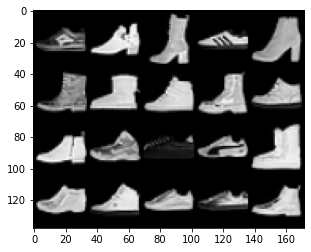

Epoch 0: Loss 2.126 Acc: 0.422
Epoch 1: Loss 1.475 Acc: 0.492
Epoch 2: Loss 0.796 Acc: 0.700
Epoch 3: Loss 0.386 Acc: 0.915
Epoch 4: Loss 0.271 Acc: 0.882
Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 10.696826457977295
generator Mean Gradients : 0.3693523243540977
discriminator Mean Gradients : 2.9074474296197494
Mean Running Discriminator Loss : 0.11679094260994424
Mean Running Generator Loss : 0.32631011972045326
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 10.413169384002686
generator Mean Gradients : 0.7663990725550066
discriminator Mean Gradients : 6.113191930238634
Mean Running Discriminator Loss : 0.10138013375368207
Mean Running Generator Loss : 0.3451718187028978
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 10.436489343643188
generator Mean Gradients : 6.8074355508

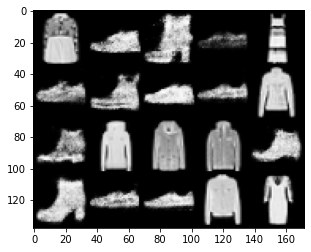

Epoch 0: Loss 2.027 Acc: 0.456
Epoch 1: Loss 0.999 Acc: 0.636
Epoch 2: Loss 0.306 Acc: 0.942
Epoch 3: Loss 0.138 Acc: 0.949
Epoch 4: Loss 0.097 Acc: 0.953
Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 10.469157457351685
generator Mean Gradients : 0.2711791828667533
discriminator Mean Gradients : 0.6318079610408284
Mean Running Discriminator Loss : 0.05581496705974829
Mean Running Generator Loss : 0.3809284518294512
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 10.846571922302246
generator Mean Gradients : 0.15829206189616604
discriminator Mean Gradients : 0.33655860412368466
Mean Running Discriminator Loss : 0.030345375443117672
Mean Running Generator Loss : 0.42122456659265656
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 10.878160953521729
generator Mean Gradients : 0.110662

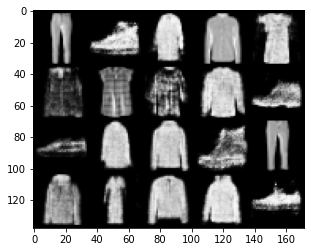

Epoch 0: Loss 1.662 Acc: 0.621
Epoch 1: Loss 0.672 Acc: 0.775
Epoch 2: Loss 0.454 Acc: 0.827
Epoch 3: Loss 0.339 Acc: 0.877
Epoch 4: Loss 0.276 Acc: 0.900
Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 12.579100847244263
generator Mean Gradients : 0.4495135818332636
discriminator Mean Gradients : 3.359998937310363
Mean Running Discriminator Loss : 0.1330437216352909
Mean Running Generator Loss : 0.3006157007940272
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 11.538639068603516
generator Mean Gradients : 1.863233275769145
discriminator Mean Gradients : 10.117746914763643
Mean Running Discriminator Loss : 0.13974073937440173
Mean Running Generator Loss : 0.3025270946165349
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 11.76828670501709
generator Mean Gradients : 3.08827373285137

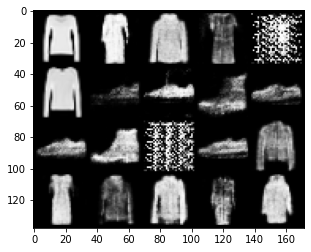

Epoch 0: Loss 1.750 Acc: 0.610
Epoch 1: Loss 0.502 Acc: 0.835
Epoch 2: Loss 0.278 Acc: 0.881
Epoch 3: Loss 0.213 Acc: 0.925
Epoch 4: Loss 0.156 Acc: 0.950
Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 10.258294582366943
generator Mean Gradients : 0.5196532262381688
discriminator Mean Gradients : 1.9472926312525631
Mean Running Discriminator Loss : 0.1286332703968312
Mean Running Generator Loss : 0.29772632814785266
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 10.983681678771973
generator Mean Gradients : 8.172116504450383
discriminator Mean Gradients : 5.85152889454731
Mean Running Discriminator Loss : 0.14076581139593047
Mean Running Generator Loss : 0.2970120781992978
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 10.074072122573853
generator Mean Gradients : 17.931709192396

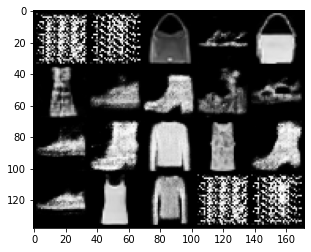

Epoch 0: Loss 1.490 Acc: 0.552
Epoch 1: Loss 0.456 Acc: 0.850
Epoch 2: Loss 0.257 Acc: 0.917
Epoch 3: Loss 0.187 Acc: 0.939
Epoch 4: Loss 0.121 Acc: 0.966


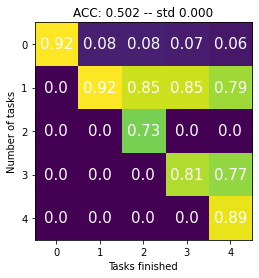

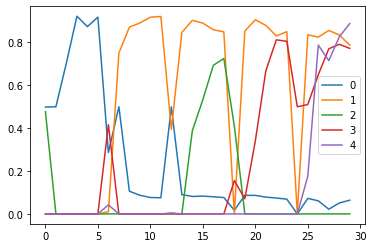

The average accuracy at the end of sequence is: 0.502
BWT:'-0.437'
FWT:'-0.125'


In [10]:
train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)
agent = Agent(args, train_tasks, val_tasks, class_split)

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")

In [11]:
## Report

As a dataset I used FashionMnist. 

Most memory is used by images and models. We are first generating images and then using them, but if we would generate them on the fly, the memory complexity would be definitely smaller. Most time is used by training GANs and this method is much slower than the one using buffers.

The scores could be better if I have found better parameters to GANs, but unfortunately no change helped.